In [786]:
class TerrainType:
    def __init__(self, texture, description, traversable_difficulty=1, buff=None):
        self.texture = texture
        self.description = description
        self.traversable_difficulty = traversable_difficulty
        self.buff = buff

In [787]:
class Cell:
    def __init__(self, x, y, terrain_type, items=None, occupied_by=None):
        self.x = x
        self.y = y
        self.terrain_type = terrain_type
        self.items = items or []
        self.occupied_by = occupied_by

    def get_traversable_difficulty(self):
        return self.terrain_type.traversable_difficulty

In [788]:
from typing import List, Tuple


class Map:
    def __init__(self, width, height) -> None:
        self.cells = [[None for i in range(width)] for j in range(height)]
        self._width = width
        self._height = height

    def in_bounds(self, x: int, y: int) -> bool:
        return 0 <= x < self._width and 0 <= y < self._height
    
    def traversable_difficulty(self, x: int, y: int) -> bool:
        return self.cells[y][x].get_traversable_difficulty()
    
    def create_cell(self, x, y, terrain_type, items=None, occupied_by=None):
        cell = Cell(x, y, terrain_type, items, occupied_by)
        self.cells[y][x] = cell
        return cell
    
    def get_neighbors(self, i: int, j: int, max_possible_traversable_difficulty, delta=None) -> List[Tuple[int, int]]:
        neighbors = []
        if delta == None:
            delta = ((0, 1), (1, 0), (0, -1), (-1, 0))
        for dx, dy in delta:
            ni, nj = i + dx, j + dy
            if self.in_bounds(ni, nj) and self.traversable_difficulty(ni, nj) <= max_possible_traversable_difficulty:
                neighbors.append((ni, nj))
        return neighbors

    def get_size(self) -> Tuple[int, int]:
        return self._height, self._width
    

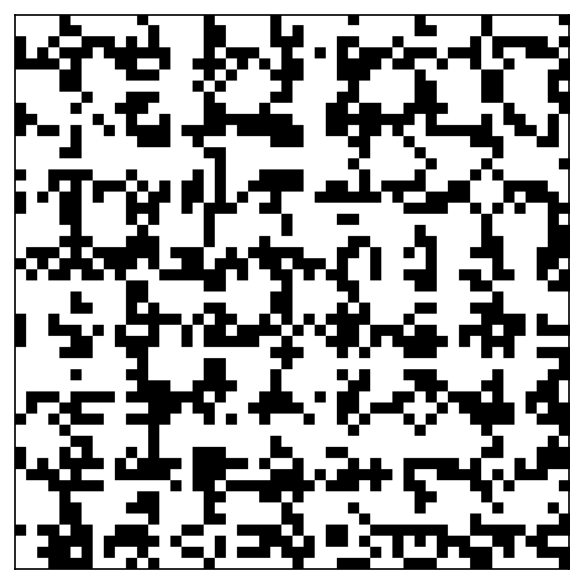

In [789]:
import matplotlib.pyplot as plt
import random
import math
from PIL import Image, ImageDraw
import numpy as np

def draw_rectangle(draw, cell, scale, color):
    """Draws a rectangle on the grid, given the node and the desired color."""
    draw.rectangle(
        (
            cell.x * scale,
            cell.y * scale,
            (cell.x + 1) * scale - 1,
            (cell.y + 1) * scale - 1,
        ),
        fill=color,
        width=0,
    )


def visualize_map(
    grid_map: Map,
    color_mapping={'#': (0, 0, 0), '.': (255, 255, 255)},
    scale=1
):
    
    height, width = grid_map.get_size()
    im = Image.new("RGB", (width * scale, height * scale), color="black")
    draw = ImageDraw.Draw(im)

    for i in range(height):
        for j in range(width):
            cell = grid_map.cells[i][j]
            color = color_mapping.get(cell.terrain_type.texture, (192, 5, 248))
            draw_rectangle(draw, cell, scale, color)

    
    _, ax = plt.subplots(dpi=150)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im), interpolation='bilinear')
    plt.show()
    im.save("map_image.png")


# ПРИМЕР ИСПОЛЬЗОВАНИЯ

# Создаем типы местности
grass_type = TerrainType(texture='.', description='Grass', traversable_difficulty=0, buff=None)
wall_type = TerrainType(texture='#', description='Wall', traversable_difficulty=1, buff=None)

terrains = [grass_type, wall_type]

# Создаем карту
game_map = Map(width=50, height=50)

# Создаем клетки с разными типами местности
for i in range(50):
    for j in range(50):
        if random.randint(1, 10) > 4:
            if math.sin(j) + math.cos(i) + random.random() >= 0.8:
                game_map.create_cell(x=j, y=i, terrain_type=grass_type)
            else:
                game_map.create_cell(x=j, y=i, terrain_type=wall_type)
        else:
            game_map.create_cell(x=j, y=i, terrain_type=grass_type)
# Визуализируем карту
visualize_map(game_map, scale=15)


In [790]:
from abc import ABC, abstractmethod

In [791]:
class MapBuilder(ABC):

    @abstractmethod
    def init_map(self):
        pass
    
    @abstractmethod
    def generate_terrain(self):
        pass

    @abstractmethod
    def generate_bioms(self):
        pass

In [792]:
class MapBuildDirector:
    def __init__(self, builder: MapBuilder):
        self.builder = builder

    def construct_map(self):
        self.builder.init_map()
        self.builder.generate_terrain()
        self.builder.generate_bioms()

    def get_map(self):
        return self.builder.map

In [793]:
import random

class RandomWalkMapBuilder(MapBuilder):
    def __init__(self, map_width, map_height, fill_terrain: TerrainType, walk_terrain: TerrainType, number_of_paths, max_path_len):
        self.map_width = map_width
        self.map_height = map_height
        self.fill_terrain = fill_terrain
        self.walk_terrain = walk_terrain
        self.number_of_paths = number_of_paths
        self.max_path_len = max_path_len

    def init_map(self):
        if self.map_height < 10 or self.map_width < 10:
            raise ValueError("Map height and width must be greater then 10")
        self.map = Map(self.map_width, self.map_height)
        self.starting_point = (self.map_width // 2, self.map_height // 2)
    
    def generate_terrain(self):
        # Делаем заливку карты
        for y in range(self.map._height):
            for x in range(self.map._width):
                self.map.create_cell(x, y, self.fill_terrain)

        current_position = self.starting_point
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        for _ in range(self.number_of_paths):
            # Выбираем случайно 3 направления из 4
            random_directions = random.sample(directions, 2)
            for _ in range(self.max_path_len):
                # Меняем направление с 30% шансом. Как показали тесты, это самый потимальный показатель
                if random.randint(0, 100) > 90:
                    random_directions = random.sample(directions, 3)
                self.map.create_cell(*current_position, self.walk_terrain)
                neighbors = self.map.get_neighbors(*current_position, max_possible_traversable_difficulty=999, delta=random_directions)
                if neighbors:
                    current_position = random.choice(neighbors)
                    if not (2 < current_position[0] < self.map_width-random.randint(1,5) and 2 < current_position[1] < self.map_height-random.randint(1,5)):
                        current_position = self.starting_point
                        break

        # Уменьшаем "шум" на карте, сглаживаем края
        for _ in range(8):
            for y in range(0, self.map._height):
                for x in range(0, self.map._width):
                    delta = [(0, 1), (1, 0), (0, -1), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)]
                    window_sum = 0
                    walls_sum = 0
                    for direction in delta:
                        dx, dy = direction
                        if self.map.in_bounds(x+dx, y+dy):
                            window_sum += 1
                            if self.map.cells[y + dy][x + dx].terrain_type == self.fill_terrain:
                                walls_sum += 1
                    if walls_sum / window_sum < 0.5:
                        self.map.cells[y][x].terrain_type = self.walk_terrain

    def generate_bioms(self):
        pass


grass_type = TerrainType(texture='.', description='Grass', traversable_difficulty=0, buff=None)
wall_type = TerrainType(texture='#', description='Wall', traversable_difficulty=2, buff=None)
builder = RandomWalkMapBuilder(200, 100, wall_type, grass_type, 30, 150)
director = MapBuildDirector(builder)
director.construct_map()
result_map = director.get_map()

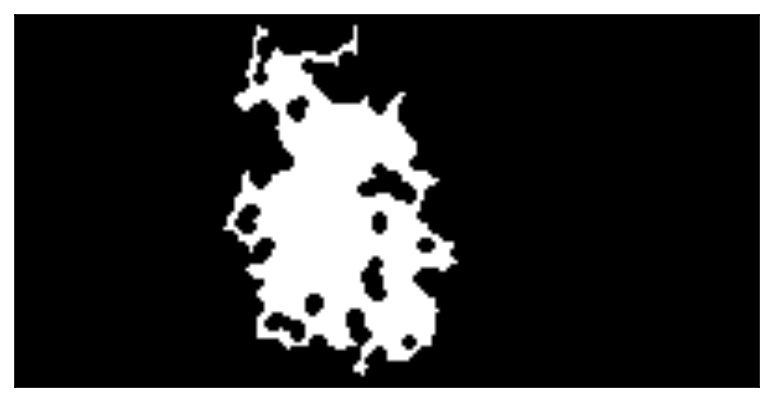

In [794]:
visualize_map(result_map)   

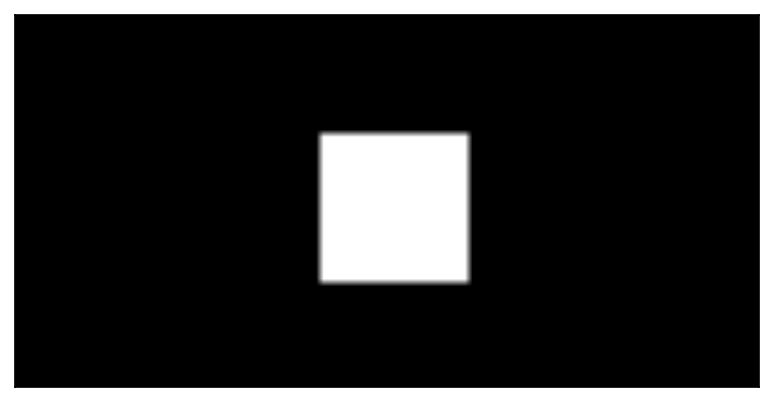

In [795]:
class TestMapBuilder(MapBuilder):
    def __init__(self, map_width, map_height):
        self.map_width = map_width
        self.map_height = map_height
        self.walk_terrain = TerrainType(texture='.', description='Grass', traversable_difficulty=0, buff=None)
        self.fill_terrain = TerrainType(texture='#', description='Wall', traversable_difficulty=2, buff=None)

    def init_map(self):
        if self.map_height < 10 or self.map_width < 10:
            raise ValueError("Map height and width must be greater then 10")
        self.map = Map(self.map_width, self.map_height)
        self.starting_point = (self.map_width // 2, self.map_height // 2)
    
    def generate_terrain(self):
        # Делаем заливку карты
        for y in range(self.map._height):
            for x in range(self.map._width):
                self.map.create_cell(x, y, self.fill_terrain)

        for dx in range(-10, 10):
            for dy in range(-10, 10):
                self.map.create_cell(self.starting_point[0]-dx, self.starting_point[1]-dy, self.walk_terrain)

    def generate_bioms(self):
        pass


builder = TestMapBuilder(100, 50)
director = MapBuildDirector(builder)
director.construct_map()
test_map = director.get_map()
visualize_map(test_map)   